<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/kalman-filters/rlabbe/rlabbe_04_1d_kalman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math

import numpy as np

from scipy.stats import norm

from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

from ipywidgets import fixed, interact
import ipywidgets as widgets

In [2]:
class Gaussian:
  def __init__(self, mean, var, name):
    self.mean = mean
    self.var = var
    self.name = name

    self.rv = norm(mean, var)

  def add(self, other, name):
    return Gaussian(self.mean + other.mean, self.var +other.var, name)

  def multiply(self, other, name):
    mean = (self.var * other.mean + other.var * self.mean) / (self.var + other.var)
    variance = (self.var * other.var) / (self.var + other.var)
    return Gaussian(mean, variance, name)


  def print(self):
    print('%s: Gaussian(%.2f, %.2f)' % (self.name, self.mean, self.var))

  def pdf(self, xs):
    return self.rv.pdf(xs)


In [3]:
def data_and_noise(x0 = 0, v = 2, a = 0, std = 1, count = 30, seed = 123):
  np.random.seed(seed)

  xs = np.array([x0 + t * v + 0.5 * a * t ** 2 for t in range(count)])
  noise = np.array(np.random.normal(0, std, count))
  return (xs, xs + noise)

In [4]:
x = Gaussian(4., 1., 'x')
y = Gaussian(2., 1.5, 'y')
x.print()
y.print()

xandy = x.add(y, 'x+y')
xandy.print()

xtimesy = x.multiply(y, 'x * y')
xtimesy.print()

x: Gaussian(4.00, 1.00)
y: Gaussian(2.00, 1.50)
x+y: Gaussian(6.00, 2.50)
x * y: Gaussian(3.20, 0.60)


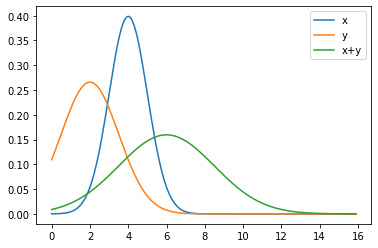

In [5]:
points = np.arange(0, 16, 0.1)
plot(points, x.pdf(points), label='x')
plot(points, y.pdf(points), label='y')
plot(points, xandy.pdf(points), label='x+y')

plt.legend()
plt.show()

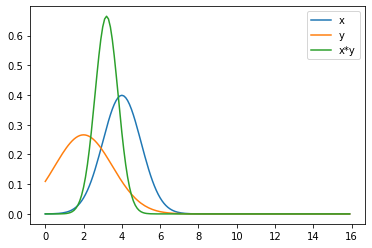

In [6]:
plot(points, x.pdf(points), label='x')
plot(points, y.pdf(points), label='y')
plot(points, xtimesy.pdf(points), label='x*y')

plt.legend()
plt.show()
